# FAST-LTS ALGORITHM

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
%matplotlib inline

## FIRST, LETS CONSTRUCT THE FAST-LTS ALGORITH

In [46]:
##########################################
# PART 0: Input validation and reshaping #
##########################################
def validate_input(X,y):
    if X is None or not isinstance(X,(list,np.ndarray)):
        raise Exception('X must be  type array or np.ndarray')
    if y is None or not isinstance(y,(list,np.ndarray)):
        raise Exception('y must be  type array or np.ndarray')
    
    if type(X) is not np.ndarray:
        X = np.asarray(X)
    if type(y) is not np.ndarray:
        y = np.asarray(y)
    
    if y.ndim != 1:
        if y.ndim != 2 or y.shape[1] != 1:
            raise ValueError('y must be 1D array')
    if y.shape[0] != X.shape[0]:
        raise ValueError('X and y must have same number of samples')
    
def reshape_and_concat(X,y, intercept=True):
    if X.ndim == 1:
        X = np.reshape(X, [X.shape[0], 1])    
    if y.ndim == 1:
        y = np.reshape(y, [y.shape[0], 1])

    if intercept:
        merged = np.concatenate([y, X, np.ones((X.shape[0],1))], axis=1)
    else:
        merged = np.concatenate([y, X], axis=1)

    return merged

########################
# PART 1: Selecting H1 #
########################
def select_initial_h1(data,h_size): 
    N = data.shape[0]
    p = data.shape[1]-1
    
    # create random permutation
    idx_all = np.random.permutation(N)
    # cut first p indexes
    idx_initial = idx_all[:p]
    # and save rest
    idx_rest = idx_all[p:]
    
    # create intial matrix of shape (p,p)
    J = data[idx_initial, :]
    
    # J[:,1:] == only X, without first y column
    rank = np.linalg.matrix_rank(J[:,1:])
    while(rank < p):
        
        if  J.shape[0] == N:
            break
            
        # get first index from rest of the indexes
        current = idx_rest[[0],]
        idx_rest = idx_rest[1:, ]

        # add row on this index -fixed, ok
        J = np.append(J, data[current,:], axis=0)
        
        # recalculate rank
        rank = np.linalg.matrix_rank(J[:,1:])
    #print('init rank: ', rank)

    #######
    # OLS #
    ####### na J
    theta_zero_hat = OLS(J)
    
    ######################
    # Absolute residuals #
    ###################### na celem N
    absolute_dist = ABS_DIST(data, theta_zero_hat)
    
    ###############################################
    # h vecotrs with smallest residuals (indexes) #
    ###############################################
    indexes_h1 = K_SMALLEST_SET(absolute_dist, h_size)
    return indexes_h1    

###############################
# PART 2: SELECTIVE ITERATION #
###############################
def make_c_steps(h1, data, cnt_steps, h_size):
    theta_old = OLS(data[h1, :])
    
    for i in range(cnt_steps):
        theta_new, h_new = c_step(theta_old, data, h_size)
        theta_old = theta_new
    
    # rss on Hnew
    squared_residuals = RSS(data[h_new, :], theta_new)
    return (theta_new, h_new, squared_residuals)

##################
# MAIN FUNCTIONS #  
##################
def RSS(input_data, theta):
    y = input_data[:,[0]]
    X = input_data[:,1:]
    
    XX = np.asmatrix(X)
    YY = np.asmatrix(y)
    
    rss = (YY - XX*theta).T * (YY - XX*theta)
    return rss
    
def OLS(input_data):
    # [0] .. diky tomu bude mit spravny shape
    y = input_data[:,[0]]
    X = input_data[:,1:]
    
    XX = np.asmatrix(X)
    YY = np.asmatrix(y)
    thetha = (XX.T*XX).I*XX.T*YY # including intercept (last)
    return thetha

def ABS_DIST(data, theta):
    y = data[:,[0]]
    X = data[:,1:]
    # Y (p+,1)
    # thetha (p+ , 1)
    # xx (n, p)
    XX = np.asmatrix(X)
    YY = np.asmatrix(y)
    return np.absolute(YY - XX*theta)    

def K_SMALLEST_SET(absolute_dist_in, k_smallest):
    absolute_dist_copy = np.copy(absolute_dist_in)
    
    indexes = np.arange(absolute_dist_copy.shape[0])
    absolute_dist = np.ravel(absolute_dist_copy)
    
    def kthSmallest(arr, indexes, left, right, k): 
        # partition
        pivot = arr[right] 
        pos = left 
        for j in range(left, right): 
            if (arr[j] <= pivot):
                arr[pos], arr[j] = arr[j], arr[pos] #swap
                indexes[pos], indexes[j] = indexes[j], indexes[pos] #swap indexes
                pos += 1
                
        arr[pos], arr[right] = arr[right], arr[pos] 
        indexes[pos], indexes[right] = indexes[right], indexes[pos] 

        # finish
        if (pos - left == k - 1): 
            return ( arr[:pos+1], indexes[:pos+1])  # values, indexes
                 
        # left part
        elif (pos - left > k - 1): 
            return kthSmallest(arr, indexes, left, pos - 1, k) 
        # right part
        return kthSmallest(arr, indexes, pos + 1, right, k - pos + left - 1) 
         
    result_values, result_indexes = kthSmallest(absolute_dist, indexes, 0, absolute_dist.shape[0] - 1, k_smallest)
    #print(result_values)
    #print(np.array( np.ravel(absolute_dist_in)[result_indexes] ) )
    return result_indexes




#########
# R U N #
#########  
# support for array and np.ndarray
# expects N > p
# expect N >=1 
# expects p >=1
# expects (n + p + 1) / 2 <= h_size <= n
# expects max_steps => 1
# expects num_start_steps => 1
# expects num_start => 1
# expects num_starts_to_finish >= 1

def fit(X,y, 
        num_starts:'number of initial starts (H1)'=500,
        num_start_c_steps:'number of initial C steps' = 2,
        num_starts_to_finish:'number of H3 which`ll to finish' = 10,
        max_c_steps:'self explanatory' = 50,
        h_size:'default := (n + p + 1) / 2' = 'default',
        use_intercept=True):
        
        validate_input(X,y)
        data = reshape_and_concat(X,y, intercept=use_intercept)
        
        # with intercept
        p = data.shape[1] - 1
        N = data.shape[0]
        
        # h_size
        if h_size == 'default':
            h_size = math.ceil(( N + p + 1 ) / 2) 

        print('h_size: ', h_size)
        
        
        # prepare for saving results
        thethas = np.empty((0,p))
        hs  = np.empty((0,h_size))
        sum_residuals = np.empty((0,1)) # only one number, but needed for sorting...
        ####
        
        # for number of starts
        for i in range(num_starts):
            
            # select initial h1
            init_h1 = select_initial_h1(data, h_size)
            
            #Selective iteration - aka. make few c steps
            # (p,1)  (h_size,) (1,1) 
            theta_new, h_new, sum_squared_residuals = make_c_steps(init_h1, data, num_start_c_steps, h_size)
            thethas = np.append(thethas,  theta_new.T , axis=0 )
            hs = np.append(hs, np.reshape(h_new, (1, h_size)), axis=0 )
            sum_residuals = np.append(sum_residuals, sum_squared_residuals, axis=0)
        
        
        ### FINAL CONVERGE
        # select x (say 10) indexes of thethas with best residuals
        best_indexes = K_SMALLEST_SET(sum_residuals, num_starts_to_finish)
        
        # one by one run c-steps on (say 10) best till convergence and save the result
        
        # REWRITE TO SOME ORDINARY SORT...
        thethas_final = np.empty((0,p))
        hs_final  = np.empty((0,h_size))
        sum_residuals_final = np.empty((0,1)) # only one number, but needed for sorting...
        
        for i in best_indexes:
            theta, h, sum_squar, conv_after_i_steps = make_c_steps_convergence(thethas[i], data, sum_residuals[i], h_size, max_c_steps)
            thethas_final = np.append(thethas_final,  theta.T , axis=0 )
            hs_final = np.append(hs_final, np.reshape(h, (1, h_size)), axis=0 )
            sum_residuals_final = np.append(sum_residuals_final, sum_squar, axis=0)
        
        # find smallest...
        best_index = K_SMALLEST_SET(sum_residuals_final, 1)
        
        # >>> OUR RESULTS <<<<
        thetha_hat_final = thethas_final[best_index[0]]
        hs_final_hs = hs_final[best_index[0]]
        sum_residuals_final_final = sum_residuals_final[best_index[0]]
        # >>>>>>><<<<<<<<<<<<<<<
        
        
        
        if use_intercept == True:
            intercept = thetha_hat_final[0, -1] # for last column, only first (and only row)
            weights = thetha_hat_final[0, :-1] # for all but last column,  only first (and only row)
            weights = np.ravel(weights) # some little tricks I dont know why...
        else:
            intercept = 0.0
            weights = thetha_hat_final[0, :] # for all but last column,  only first (and only row)
            weights = np.ravel(weights) # some little tricks I dont know why...

        print('intercept: ', intercept)
        print('weights: ', weights)
        print('rss: ', np.asarray(sum_residuals_final_final)[0][0])
        
        plt.figure(figsize=(12,8))
        # plt.scatter(x=X, y=y) # yup those are original X y...
        
        hs_final_hs =  np.ravel(  hs_final_hs.astype(int) )
        
        # niffty trick
        data_used = data[hs_final_hs, :]
        mask = np.ones(data.shape[0], np.bool)
        mask[hs_final_hs] = 0
        data_not_used = data[mask]
        
        if use_intercept == True:
            y_used = data_used[:,[0]]
            X_used = data_used[:,1:-1]
            y_not_used = data_not_used[:,[0]]
            X_not_used = data_not_used[:,1:-1]
            y = data[:,[0]]
            X = data[:,1:-1]
        else:
            y_used = data_used[:,[0]]
            X_used = data_used[:,1:]
            y_not_used = data_not_used[:,[0]]
            X_not_used = data_not_used[:,1:]
            y = data[:,[0]]
            X = data[:,1:]
            
        plt.plot(X_not_used, y_not_used, 'b.')
        plt.plot(X_used, y_used, 'r.')
        plt.plot(X, weights * X + intercept, '-')
        plt.show()
        
def make_c_steps_convergence(theta_old, data, sum_old, h_size, max_steps, tolerance=1e-6):
    #print(theta_old.shape)
    # thetha has bad shape here, lets reshape it
    theta_old = theta_old.T
    for i in range(max_steps):
        theta_new, h_new = c_step(theta_old, data, h_size) # chyba tady
        sum_new = RSS(data[h_new, :], theta_new)
        
        if math.isclose(sum_old, sum_new, rel_tol=tolerance) == True:
            break
        sum_old = sum_new
        theta_old = theta_new
    return (theta_new, h_new, sum_new, i)
    
def c_step(theta_old, data, h_size):
    abs_residuals = ABS_DIST(data, theta_old) # chyba tady
    h_new = K_SMALLEST_SET(abs_residuals, h_size)
    theta_new = OLS(data[h_new,:])
    return (theta_new, h_new)

## Now, lets generate some data

In [47]:
# LINEAR DATA
# data generated same way as in Rousseeuw and Driessen 2000
X_original = np.random.normal(loc=0,scale=10, size=800) # var = 100
e = np.random.normal(loc=0,scale=1, size=800) # var = 1
y_original = 1 + X_original + e

# OUTLIERS
# multivariate N(mean = location, covariance)
# diagonalni 25 I
outliers = np.random.multivariate_normal(mean = [50, 0], 
                                         cov = [[25, 0], [0, 25]], 
                                         size=200)

# FINAL DATA
X = np.concatenate((X_original,outliers.T[0]), axis=0)
y = np.concatenate((y_original,outliers.T[1]), axis=0)

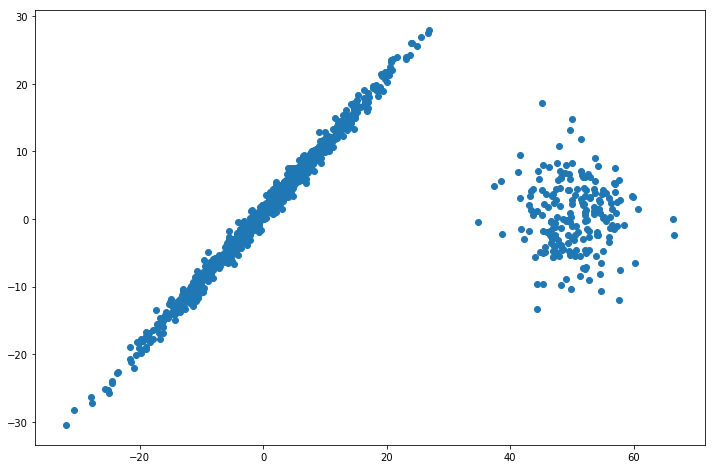

In [48]:
plt.figure(figsize=(12,8))
plt.scatter(x=X, y=y)

## And now, lets test our algorithm

h_size:  501
intercept:  0.0
weights:  [1.00819452]
rss:  306.25634039819613


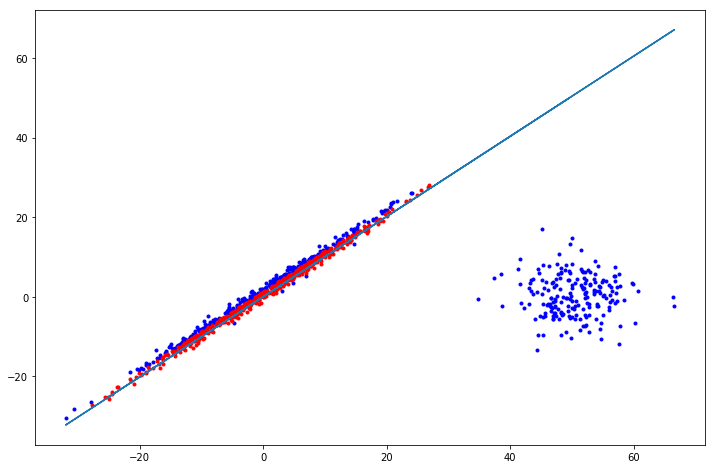

In [49]:
fit(X,y, use_intercept=False)

h_size:  502
intercept:  1.0017095394011368
weights:  [0.9889881]
rss:  106.00568461717941


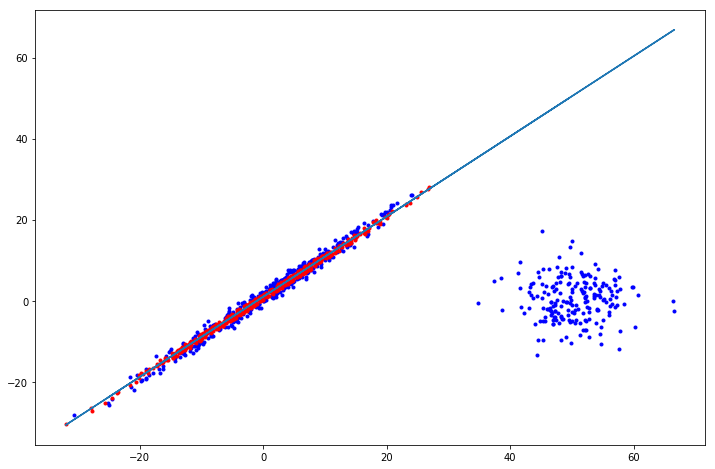

In [50]:
fit(X,y, use_intercept=True)

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import math
import time


# currently support for np.ndarray and matrix
def val_and_reshap(X, y, h_size, num_start_c_steps, num_starts_to_finish, max_c_steps, threshold, use_intercept):
    if X is None or not isinstance(X, (np.ndarray, np.matrix)):
        raise Exception('X must be  type array or np.ndarray or np.matrix')
    if y is None or not isinstance(y, (np.ndarray, np.matrix)):
        raise Exception('y must be  type array or np.ndarray or np.matrix')

    if X.ndim == 1:
        X = np.reshape(X, [X.shape[0], 1])
    if y.ndim == 1:
        y = np.reshape(y, [y.shape[0], 1])

    if type(X) is not np.matrix:
        X = np.asmatrix(X)
    if type(y) is not np.matrix:
        y = np.asmatrix(y)

    if y.ndim != 1:
        if y.ndim != 2 or y.shape[1] != 1:
            raise ValueError('y must be 1D array')
    if y.shape[0] != X.shape[0]:
        raise ValueError('X and y must have same number of samples')

    if X.shape[0] < 1:  # expects N >= 1
        raise ValueError('You must provide at least one sample')

    if X.ndim < 1:  # expects p >=1
        raise ValueError('X has zero dimensions')

    if h_size != 'default':
        if h_size > X.shape[0]:
            raise ValueError('H_size must not be > number of samples')
        if h_size < 1:
            raise ValueError('H_size must be > 0 ; preferably (n + p + 1) / 2 <= h_size <= n ')

    if max_c_steps < 1:  # expects max_steps => 1
        raise ValueError('max_c_steps must be >= 1')

    if num_start_c_steps < 1:  # expects num_start_steps => 1
        raise ValueError('num_start_c_steps must be >= 1')

    if num_starts_to_finish < 1:  # expects num_starts_to_finish >= 1
        raise ValueError('num_starts_to_finish must be >= 1')

    if threshold < 0:  # expects threshold >= 0
        raise ValueError('threshold must be >= 0')

    if use_intercept:
        merged = np.concatenate([y, X, np.ones((X.shape[0], 1))], axis=1)
    else:
        merged = np.concatenate([y, X], axis=1)

    return np.asmatrix(merged)


def make_c_steps(h1, data, cnt_steps, h_size): # vola se 500x
    theta_old = OLS(data[h1, :])


    for i in range(cnt_steps):  # vola se 2x
        theta_new, h_new = c_step(theta_old, data, h_size)
        theta_old = theta_new

    # rss on Hnew
    squared_residuals = RSS(data[h_new, :], theta_new)
    return theta_new, h_new, squared_residuals


def make_c_steps_convergence(theta_old, data, sum_old, h_size, max_steps, threshold):  # vola se 10x
    # print(theta_old.shape)
    # thetha has bad shape here, lets reshape it
    #theta_old = theta_old.T
    #theta_old = np.reshape(theta_old, (theta_old.shape[0], 1))

    for i in range(max_steps):  # vola se 50 x
        theta_new, h_new = c_step(theta_old, data, h_size)  # chyba tady
        sum_new = RSS(data[h_new, :], theta_new)

        if math.isclose(sum_old, sum_new, rel_tol=threshold):
            break

        sum_old = sum_new
        theta_old = theta_new
    return theta_new, h_new, sum_new, i


def c_step(theta_old, data, h_size):
    abs_residuals = ABS_DIST(data, theta_old)  # chyba tady
    h_new = K_SMALLEST_SET(abs_residuals, h_size)
    theta_new = OLS(data[h_new, :])
    return theta_new, h_new


class SelectiveIterationResults:
    def __init__(self, arr_theta_hat, arr_h_index, arr_rss):
        self.arr_theta_hat = arr_theta_hat
        self.arr_h_index = arr_h_index
        self.arr_rss = arr_rss


class FastLtsRegression:
    def __init__(self):
        self._data = None
        self._p = None
        self._N = None
        self._h_size = None
        # public
        self.n_iter_ = None
        self.coef_ = None
        self.intercept_ = None
        self.h_subset_ = None
        self.rss_ = None

    def fit(self, X, y,
            num_starts: 'number of initial starts (H1)' = 500,
            num_start_c_steps: 'number of initial C steps' = 2,
            num_starts_to_finish: 'number of H3 which`ll to finish' = 10,
            max_c_steps: 'self explanatory' = 50,
            h_size: 'default := (n + p + 1) / 2' = 'default',
            use_intercept=True,
            threshold: 'stopping criterion for Qold Qnew sum residuals in c-steps' = 1e-6):

        # Init some properties
        self._data = val_and_reshap(X, y, h_size, num_start_c_steps, num_starts_to_finish, max_c_steps, threshold,
                                    use_intercept)
        self._p = self._data.shape[1] - 1
        self._N = self._data.shape[0]

        if h_size == 'default':
            self._h_size = math.ceil((self._N + self._p + 1) / 2)  # todo with or without intercept?
        else:
            self._h_size = h_size

        # Selective iteration := h1 + few c-steps + find few with best rss
        results = self.selective_iteration(num_starts, num_start_c_steps)  # todo time:
        arr_best_idx = K_SMALLEST_SET(results.arr_rss, num_starts_to_finish)  # todo time: O(N)

        # C-steps till convergence, store number of iterations
        final_results, self.n_iter_ = self.iterate_till_convergence(results, arr_best_idx, max_c_steps, threshold)
        arr_final_idx = K_SMALLEST_SET(final_results.arr_rss, 1)

        # Store results
        # theta_final = final_results.arr_theta_hat[arr_final_idx[0]].A1
        # if use_intercept:
        #     self.intercept_ = theta_final[-1]  # for last column, only first (and only row)
        #     self.coef_ = theta_final[:-1]  # for all but last column,  only first (and only row)
        # else:
        #     self.intercept_ = 0.0
        #     self.coef_ = theta_final  # for all but last column,  only first (and only row)
        # 
        # self.h_subset_ = final_results.arr_h_index[arr_final_idx[0]].astype(int)
        # self.rss_ = final_results.arr_rss[arr_final_idx[0]].A1[0]

    # Select initial H1
    def select_initial_h1(self):
        if self._p >= self._N:
            J = self._data
        else:
            # create random permutation
            idx_all = np.random.permutation(self._N)
            # cut first p indexes and save the rest
            idx_initial = idx_all[:self._p]
            idx_rest = idx_all[self._p:]

            # create initial matrix of shape (p,p)
            J = self._data[idx_initial, :]

            # J[:,1:] == only X, without first y column
            rank = np.linalg.matrix_rank(J[:, 1:])

            while rank < self._p and J.shape[0] < self._N:
                # get first index from rest of the indexes
                current = idx_rest[[0],]
                idx_rest = idx_rest[1:, ]

                # add row on this index -fixed, ok
                J = np.append(J, self._data[current, :], axis=0)

                # and recalculate rank
                rank = np.linalg.matrix_rank(J[:, 1:])

        # OLS on J
        theta_zero_hat = OLS(J)

        # abs dist on N, and return h smallest
        abs_residuals = ABS_DIST(self._data, theta_zero_hat)
        return K_SMALLEST_SET(abs_residuals, self._h_size)

    class Storage:
        def __init__(self, a, b):
            self.data = []
            self.a = a
            self.b = b

        def update(self, row):
            for r in row:
                self.data.append(r)

        def finalize(self):
            return np.reshape(self.data, newshape=(self.a, self.b))

    def selective_iteration(self, num_starts, num_start_c_steps):
        start_time = time.time()

        # arr_theta_hat = np.empty((0, self._p))
        # arr_h_subset = np.empty((0, self._h_size))
        # arr_rss = np.empty((0, 1))  # only one number, but needed for sorting...

        arr_theta_hat = []
        arr_h_subset = []
        arr_rss = []

        # for number of starts
        for i in range(num_starts):  # todo time O(num_starts * (n-p) * matrixSVD(pxp))
            # select initial h1
            init_h1 = self.select_initial_h1()  # todo time: (n-p) * matrixSVD(pxp) CANT GO BETTER ?? [BINARY -- ?]

            # make few c-steps
            # (p,1)  (h_size,) (1,1)
            theta, h_subset, rss = make_c_steps(init_h1, self._data, num_start_c_steps, self._h_size)
            arr_theta_hat.append(theta)
            arr_h_subset.append(h_subset)
            arr_rss.append(rss.A1)

            # arr_theta_hat = np.append(arr_theta_hat, theta.T, axis=0)
            # arr_h_subset = np.append(arr_h_subset, np.reshape(h_subset, (1, self._h_size)), axis=0)
            # arr_rss = np.append(arr_rss, rss, axis=0)

        arr_theta_hat = np.asarray(arr_theta_hat)
        arr_h_subset = np.asarray(arr_h_subset)
        arr_rss = np.asarray(arr_rss)
        elapsed_time = time.time() - start_time
        print('selective iteration', elapsed_time)  # 70 - 80

        return SelectiveIterationResults(arr_theta_hat, arr_h_subset, arr_rss)

    def iterate_till_convergence(self, results, arr_best_idx, max_c_steps, threshold):
        start_time = time.time()
        # arr_theta_hat = np.empty((0, self._p))
        # arr_h_subset = np.empty((0, self._h_size))
        # arr_rss = np.empty((0, 1))  # only one number, but needed for sorting...

        arr_theta_hat = []
        arr_h_subset = []
        arr_rss = []

        n_iter = 0
        print(results.arr_theta_hat[0].shape)
        for i in arr_best_idx:
            theta, h_subset, rss, n_iter = make_c_steps_convergence(results.arr_theta_hat[i],
                                                                    self._data,
                                                                    results.arr_rss[i],
                                                                    self._h_size,
                                                                    max_c_steps, threshold)

            # arr_theta_hat = np.append(arr_theta_hat, theta.T, axis=0)
            # arr_h_subset = np.append(arr_h_subset, np.reshape(h_subset, (1, self._h_size)), axis=0)
            # arr_rss = np.append(arr_rss, rss, axis=0)

            arr_theta_hat.append(theta)
            arr_h_subset.append(h_subset)
            arr_rss.append(rss)

        arr_theta_hat = np.asarray(arr_theta_hat)
        arr_h_subset = np.asarray(arr_h_subset)
        arr_rss = np.asarray(arr_rss)
        elapsed_time = time.time() - start_time
        print('iterate till convergence', elapsed_time)  #

        return SelectiveIterationResults(arr_theta_hat, arr_h_subset, arr_rss), n_iter


##################
# MAIN FUNCTIONS #
##################
def RSS(input_data, theta):
    y = input_data[:, [0]]
    x = input_data[:, 1:]
    return (y - x * theta).T * (y - x * theta)


def OLS(input_data):
    # [0] .. diky tomu bude mit spravny shape
    y = input_data[:, [0]]
    x = input_data[:, 1:]
    return (x.T * x).I * x.T * y  # including intercept (last)


def ABS_DIST(data, theta):
    y = data[:, [0]]
    x = data[:, 1:]
    # Y (p+,1)
    # thetha (p+ , 1)
    # xx (n, p)
    return np.absolute(y - x * theta)


def K_SMALLEST_SET(absolute_dist_in, k_smallest):
    absolute_dist_copy = np.copy(absolute_dist_in)

    indexes = np.arange(absolute_dist_copy.shape[0])
    absolute_dist = np.ravel(absolute_dist_copy)

    def kthSmallest(arr, indexes, left, right, k):
        # partition
        pivot = arr[right]
        pos = left
        for j in range(left, right):
            if arr[j] <= pivot:
                arr[pos], arr[j] = arr[j], arr[pos]  # swap
                indexes[pos], indexes[j] = indexes[j], indexes[pos]  # swap indexes
                pos += 1

        arr[pos], arr[right] = arr[right], arr[pos]
        indexes[pos], indexes[right] = indexes[right], indexes[pos]

        # finish
        if pos - left == k - 1:
            return arr[:pos + 1], indexes[:pos + 1]  # values, indexes

        # left part
        elif pos - left > k - 1:
            return kthSmallest(arr, indexes, left, pos - 1, k)
            # right part
        return kthSmallest(arr, indexes, pos + 1, right, k - pos + left - 1)

    result_values, result_indexes = kthSmallest(absolute_dist, indexes, 0, absolute_dist.shape[0] - 1, k_smallest)
    return result_indexes

In [2]:


def make_c_steps_convergence_2(theta_old, data, sum_old, h_size, max_steps, threshold):  # vola se 10x
    # print(theta_old.shape)
    # thetha has bad shape here, lets reshape it
    theta_old = theta_old.T
    #theta_old = np.reshape(theta_old, (theta_old.shape[0], 1))

    for i in range(max_steps):  # vola se 50 x
        theta_new, h_new = c_step(theta_old, data, h_size)  # chyba tady
        sum_new = RSS(data[h_new, :], theta_new)

        if math.isclose(sum_old, sum_new, rel_tol=threshold):
            break

        sum_old = sum_new
        theta_old = theta_new
    return theta_new, h_new, sum_new, i


class FastLtsRegression_numpy:
    def __init__(self):
        self._data = None
        self._p = None
        self._N = None
        self._h_size = None
        # public
        self.n_iter_ = None
        self.coef_ = None
        self.intercept_ = None
        self.h_subset_ = None
        self.rss_ = None

    def fit(self, X, y,
            num_starts: 'number of initial starts (H1)' = 500,
            num_start_c_steps: 'number of initial C steps' = 2,
            num_starts_to_finish: 'number of H3 which`ll to finish' = 10,
            max_c_steps: 'self explanatory' = 50,
            h_size: 'default := (n + p + 1) / 2' = 'default',
            use_intercept=True,
            threshold: 'stopping criterion for Qold Qnew sum residuals in c-steps' = 1e-6):

        # Init some properties
        self._data = val_and_reshap(X, y, h_size, num_start_c_steps, num_starts_to_finish, max_c_steps, threshold,
                                    use_intercept)
        self._p = self._data.shape[1] - 1
        self._N = self._data.shape[0]

        if h_size == 'default':
            self._h_size = math.ceil((self._N + self._p + 1) / 2)  # todo with or without intercept?
        else:
            self._h_size = h_size

        # Selective iteration := h1 + few c-steps + find few with best rss
        results = self.selective_iteration(num_starts, num_start_c_steps)  # todo time:
        arr_best_idx = K_SMALLEST_SET(results.arr_rss, num_starts_to_finish)  # todo time: O(N)

        # C-steps till convergence, store number of iterations
        final_results, self.n_iter_ = self.iterate_till_convergence(results, arr_best_idx, max_c_steps, threshold)
        arr_final_idx = K_SMALLEST_SET(final_results.arr_rss, 1)

        # Store results
        theta_final = final_results.arr_theta_hat[arr_final_idx[0]].A1
        if use_intercept:
            self.intercept_ = theta_final[-1]  # for last column, only first (and only row)
            self.coef_ = theta_final[:-1]  # for all but last column,  only first (and only row)
        else:
            self.intercept_ = 0.0
            self.coef_ = theta_final  # for all but last column,  only first (and only row)

        self.h_subset_ = final_results.arr_h_index[arr_final_idx[0]].astype(int)
        self.rss_ = final_results.arr_rss[arr_final_idx[0]].A1[0]

    # Select initial H1
    def select_initial_h1(self):
        if self._p >= self._N:
            J = self._data
        else:
            # create random permutation
            idx_all = np.random.permutation(self._N)
            # cut first p indexes and save the rest
            idx_initial = idx_all[:self._p]
            idx_rest = idx_all[self._p:]

            # create initial matrix of shape (p,p)
            J = self._data[idx_initial, :]

            # J[:,1:] == only X, without first y column
            rank = np.linalg.matrix_rank(J[:, 1:])

            while rank < self._p and J.shape[0] < self._N:
                # get first index from rest of the indexes
                current = idx_rest[[0],]
                idx_rest = idx_rest[1:, ]

                # add row on this index -fixed, ok
                J = np.append(J, self._data[current, :], axis=0)

                # and recalculate rank
                rank = np.linalg.matrix_rank(J[:, 1:])

        # OLS on J
        theta_zero_hat = OLS(J)

        # abs dist on N, and return h smallest
        abs_residuals = ABS_DIST(self._data, theta_zero_hat)
        return K_SMALLEST_SET(abs_residuals, self._h_size)

    class Storage:
        def __init__(self, a, b):
            self.data = []
            self.a = a
            self.b = b

        def update(self, row):
            for r in row:
                self.data.append(r)

        def finalize(self):
            return np.reshape(self.data, newshape=(self.a, self.b))

    def selective_iteration(self, num_starts, num_start_c_steps):
        start_time = time.time()

        arr_theta_hat = np.empty((0, self._p))
        arr_h_subset = np.empty((0, self._h_size))
        arr_rss = np.empty((0, 1))  # only one number, but needed for sorting...

        # arr_theta_hat = []
        # arr_h_subset = []
        # arr_rss = []

        # for number of starts
        for i in range(num_starts):  # todo time O(num_starts * (n-p) * matrixSVD(pxp))
            # select initial h1
            init_h1 = self.select_initial_h1()  # todo time: (n-p) * matrixSVD(pxp) CANT GO BETTER ?? [BINARY -- ?]

            # make few c-steps
            # (p,1)  (h_size,) (1,1)
            theta, h_subset, rss = make_c_steps(init_h1, self._data, num_start_c_steps, self._h_size)
            # arr_theta_hat.append(theta)
            # arr_h_subset.append(h_subset)
            # arr_rss.append(rss.A1)

            arr_theta_hat = np.append(arr_theta_hat, theta.T, axis=0)
            arr_h_subset = np.append(arr_h_subset, np.reshape(h_subset, (1, self._h_size)), axis=0)
            arr_rss = np.append(arr_rss, rss, axis=0)

        # arr_theta_hat = np.asarray(arr_theta_hat)
        # arr_h_subset = np.asarray(arr_h_subset)
        # arr_rss = np.asarray(arr_rss)
        elapsed_time = time.time() - start_time
        print('selective iteration', elapsed_time)  # 70 - 80

        return SelectiveIterationResults(arr_theta_hat, arr_h_subset, arr_rss)

    def iterate_till_convergence(self, results, arr_best_idx, max_c_steps, threshold):
        start_time = time.time()
        arr_theta_hat = np.empty((0, self._p))
        arr_h_subset = np.empty((0, self._h_size))
        arr_rss = np.empty((0, 1))  # only one number, but needed for sorting...

        # arr_theta_hat = []
        # arr_h_subset = []
        # arr_rss = []

        n_iter = 0
        print(results.arr_theta_hat[0].shape)
        for i in arr_best_idx:
            theta, h_subset, rss, n_iter = make_c_steps_convergence_2(results.arr_theta_hat[i],
                                                                    self._data,
                                                                    results.arr_rss[i],
                                                                    self._h_size,
                                                                    max_c_steps, threshold)

            arr_theta_hat = np.append(arr_theta_hat, theta.T, axis=0)
            arr_h_subset = np.append(arr_h_subset, np.reshape(h_subset, (1, self._h_size)), axis=0)
            arr_rss = np.append(arr_rss, rss, axis=0)

            # arr_theta_hat.append(theta)
            # arr_h_subset.append(h_subset)
            # arr_rss.append(rss)

        # arr_theta_hat = np.asarray(arr_theta_hat)
        # arr_h_subset = np.asarray(arr_h_subset)
        # arr_rss = np.asarray(arr_rss)
        elapsed_time = time.time() - start_time
        print('iterate till convergence', elapsed_time)  #

        return SelectiveIterationResults(arr_theta_hat, arr_h_subset, arr_rss), n_iter

In [ ]:
if __name__ == '__main__':
    # LINEAR DATA
    # data generated same way as in Rousseeuw and Driessen 2000
    X_original = np.random.normal(loc=0, scale=10, size=8000)  # var = 100
    e = np.random.normal(loc=0, scale=1, size=8000)  # var = 1
    y_original = 1 + X_original + e

    # OUTLIERS
    # multivariate N(mean = location, covariance)
    # diagonalni 25 I
    outliers = np.random.multivariate_normal(mean=[50, 0],
                                             cov=[[25, 0], [0, 25]],
                                             size=200)

    # FINAL DATA
    X = np.concatenate((X_original, outliers.T[0]), axis=0)
    y = np.concatenate((y_original, outliers.T[1]), axis=0)

In [7]:
    lts = FastLtsRegression_numpy()
    lts.fit(X, y, use_intercept=True)
    
    lts2 = FastLtsRegression()
    lts2.fit(X, y, use_intercept=True)

selective iteration 71.59840273857117
(1, 2)
iterate till convergence 7.511356830596924
selective iteration 70.21922659873962
(2, 1)
iterate till convergence 7.968839883804321


In [ ]:
#numpy
#66, 73, 71
#7, 6, 7
#python
#66, 74, 71
#8, 10, 8